## Do it! Natural Language Processing using BERT and GPT - part5
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 5. 문장 쌍 분류하기
### 5.1 문서 쌍 분류 모델 훑어보기

#### 자연어 추론 : 2개의 문장(문서)이 참, 거짓, 중립 또는 판단 불가인 지 가려내는 것

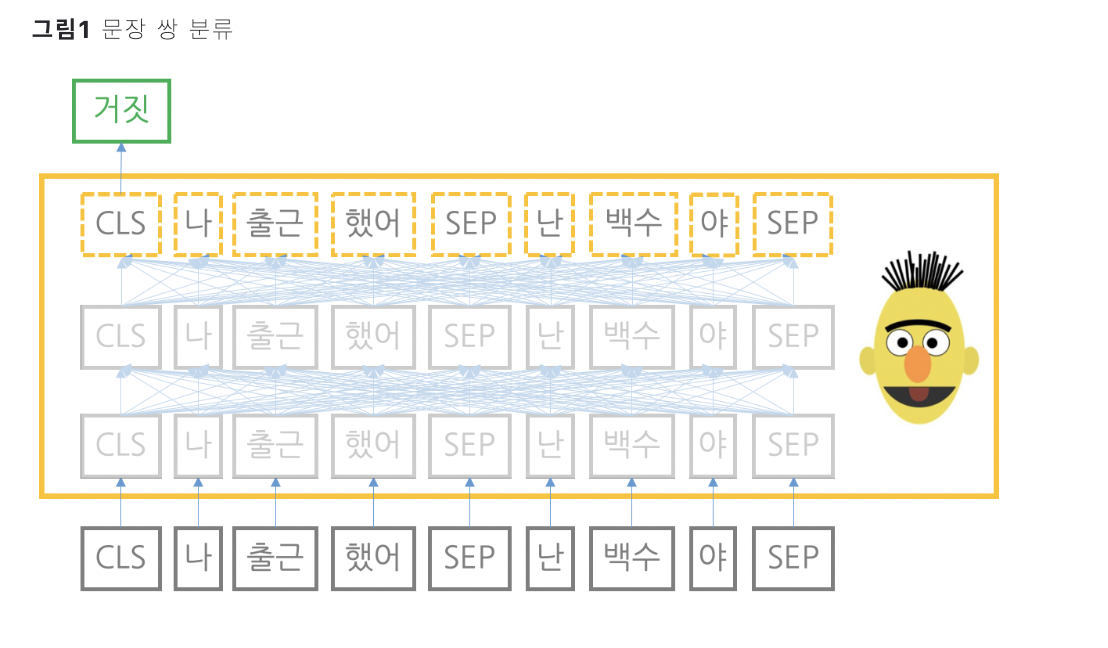
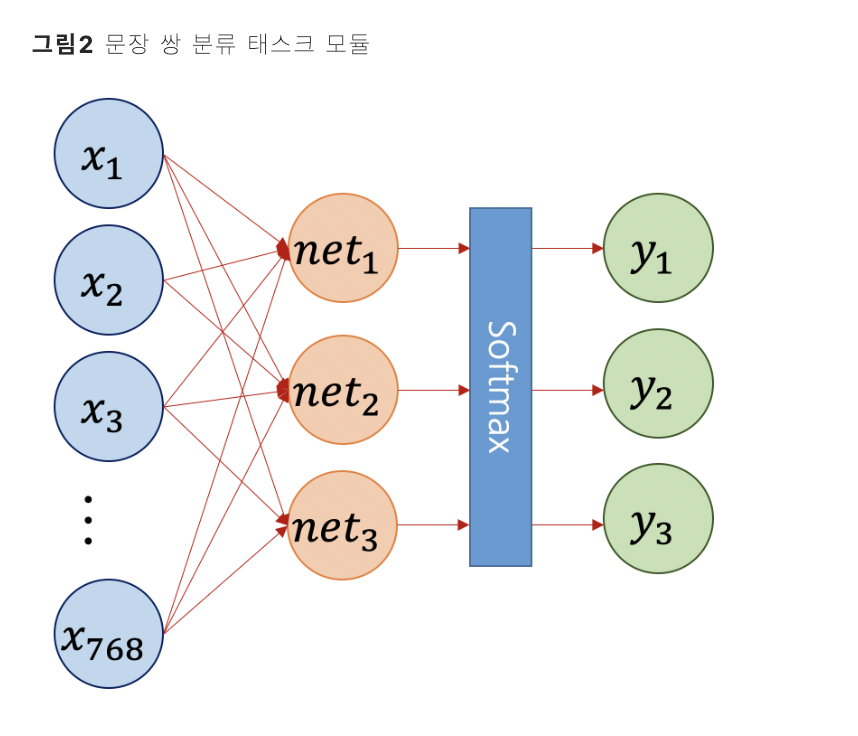

### 5.2 문장 쌍 분류 모델 학습하기

In [ ]:
#### 모델 환경 설정
import torch 
from ratsnlp.nlpbook.classification import ClassificationTrainArguments
args = ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base',
                                    downstream_task_name='pair-classification',
                                    downstream_corpus_name='klue-nli',
                                    downstream_model_dir='./part4-model',
                                    batch_size=32 if torch.cuda.is_available() else 4,
                                    learning_rate=5e-5,
                                    max_seq_length = 64,
                                    epochs = 5, 
                                    tpu_cores=0 if torch.cuda.is_available() else 8,
                                    seed = 7
)

#### 랜덤시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

#### 로거 설정
import nlpbook
nlpbook.set_logger(args)

#### 말뭉치 내려 받기
nlpbook.download_downstream_dataset(args)

#### 토그나이저 준비
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case =False)

#### 학습 데이터셋 구축
from ratsnlp.nlpbook.paircls import KlueNLICorpus
from ratsnlp.nlpbook.classification import ClassificationDataset
corpus = KlueNLICorpus()
train_dataset = ClassificationDataset(args=args, corpus=corpus, tokenizer=tokenizer, mode ='train')

#### 학습 데이터로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset, replacement=False),
                              collate_fn=nlpbook.data_collator, drop_last =False, num_workers=args.cpu_workers,)

#### 평가용 데이터로더 구축
val_dataset = ClassificationDataset(args=args, corpus=corpus, tokenizer=tokenizer, mode='test')
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, sampler=RandomSampler(val_dataset),
                           collate_fn=nlpbook.data_collator, drop_last=False, num_workers=args.cpu_workers)


#### 모델 초기화
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, num_labels=corpus.num_labels)
model = BertForSequenceClassification.from_pretrained(args.pretrained_model_name, config = pretrained_model_config)

#### 태스크 정의
from ratsnlp.nlpbook.classification import ClassificationTask
task = ClassificationTask(model, args)

#### 트레이너 정의
trainer = nlpbook.get_trainer(args)

#### 학습 개시
trainer.fit(task, train_dataloader = train_dataloader, val_dataloaders = val_dataloader)

### 5.3 학습 마친 모델을 실전 투입하기

In [1]:
#### 인퍼런스 설정
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(pretrained_model_name = 'beomi/kcbert-base',
                                    downstream_model_dir = './part4-model',
                                    max_seq_length = 64)

#### 토크나이저 및 모델 불러오기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case = False)

#### 체크포인트 로드 
import torch
fine_tuned_model_ckpt = torch.load(args.downstream_model_checkpoint_fpath, map_location=torch.device('cpu'))

#### Bert 설정 로드
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel())

#### Bert 모델 초기화
from transformers import BertForSequenceClassification
model = BertForSequenceClassification(pretrained_model_config)

#### 체크포인트 주입하기
model.load_state_dict({k.replace("model.", "") : v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

#### 평가 모드로 전환
model.eval()

#### 인퍼런스 함수 
def inference_fn(premise, hypothesis):
    inputs = tokenizer([(premise, hypothesis)],
                      max_length=args.max_seq_length,
                      padding = 'max_length',
                      truncation=True)
    
    with torch.no_grad():
        outputs = model(**{k:torch.tensor(v) for k, v in inputs.items()})
        prob = outputs.logits.softmax(dim=1)
        entailment_prob = round(prob[0][0].item(), 2)
        contradiction_prob = round(prob[0][1].item(), 2)
        neutral_prob = round(prob[0][2].item(), 2)
        
        if torch.argmax(prob) ==0:
            pred = "참 (entailment)"
        elif torch.argmax(prob) == 1:
            pred = "거짓 (contradiction)"
        else:
            pred = "중립 (neutral)"
            
    return {
        "premise" : premise,
        "hypothesis" : hypothesis,
        "prediction" : pred,
        "entailment_data" : f"참 {entailment_prob}",
        "contradiction_data" : f"거짓 {contradiction_prob}",
        "neutral_data" : f"중립 {neutral_prob}",
        "entailment_width" : f"{entailment_prob * 100}%",
        "contradiction_width" : f"{contradiction_prob * 100}%",
        "neural_width" : f"{neutral_prob * 100}%"
    }